In [33]:
import cv2
import numpy as np
import pdb
import os
import math

In [2]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from matplotlib.colors import hsv_to_rgb

In [3]:
def image_print(img):
	"""
	Helper function to print out images, for debugging. Pass them in as a list.
	Press any key to continue.
	"""
	cv2.imshow("image", img)
	cv2.waitKey(0)
	cv2.destroyAllWindows()

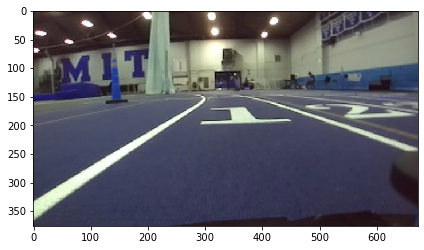

In [169]:
img1 = cv2.imread("track_img/1.png") #track_img/c2.png
imshow(img1)
# cv2.imshow('image',img1)

In [170]:
img1.shape

(376, 672, 3)

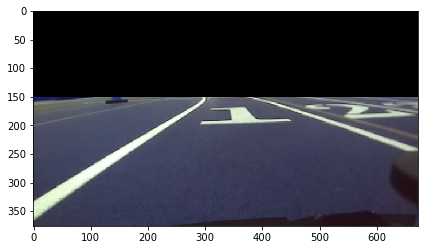

In [171]:
#line following box 
start_point1 = (0, 0) #top rectangle 
end_point1 = (676, 150) #top rectangle: just edit y_coordinate for line_follower

thickness = -1 
color = (0, 0, 0) # Black color in BGR
img_line= cv2.rectangle(img1, start_point1, end_point1, color, thickness)

# start_point2 = (0, 300) #bottom rectangle: just edit y_coordinate for line follower
# end_point2 = (672, 376) #bottom rectangle 
# img_line= cv2.rectangle(img_line, start_point2, end_point2, color, thickness)
imshow(img_line)
img1 = img_line

In [172]:
img_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(img_hsv)
# image_print(img_hsv)

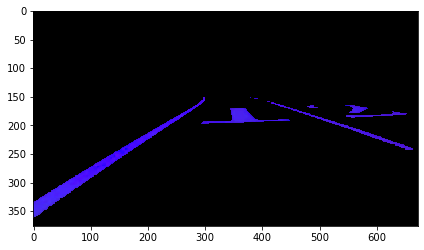

In [173]:
img_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)

lower_white = np.array([0,0,200])
upper_white = np.array([179,255,255])
  
mask = cv2.inRange(img_hsv, lower_white, upper_white)  
masked_img = cv2.bitwise_and(img_hsv, img_hsv, mask=mask).astype('uint8')
imshow(masked_img)

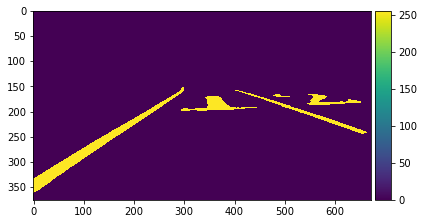

In [174]:
hsv_image = masked_img#cv2.cvtColor(img_masked2, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_image)

ret, th1 = cv2.threshold(h,180,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
kernel = np.ones((1,1), dtype = "uint8")/9
bilateral = cv2.bilateralFilter(th1, 9 , 75, 75)
erosion = cv2.erode(bilateral, kernel, iterations = 1)

#finding the area of all connected white pixels in the image
pixel_components, output, stats, centroids =cv2.connectedComponentsWithStats(erosion, connectivity=8)

area = stats[1:, -1]; pixel_components = pixel_components - 1

min_size = 50

img2 = np.zeros((output.shape))

#Removing the small white pixel area below the minimum size
for i in range(0, pixel_components):
    if area[i] >= min_size:
        img2[output == i + 1] = 255
        
# img3 = img2.astype(np.uint8) 
# # find contours in the thresholded image
# cnts, _ = cv2.findContours(img3.copy(), cv2.RETR_TREE,
#                         cv2.CHAIN_APPROX_SIMPLE)

# img_ma = img_dilation.copy()
# img_ma = cv2.drawContours(img_ma,cnts[0],0,(0,255,255),2)

# rect = cv2.boundingRect(cnts[0])
# x,y,w,h = rect
# img_ma = cv2.rectangle(img1, (x,y),(x+w,y+h),(0,255,0),2)

imshow(img2)

https://docs.opencv.org/4.7.0/d9/db0/tutorial_hough_lines.html

In [175]:
def get_slope(pt1,pt2):
    try:
        return (pt1[1]-pt2[1])/(pt1[0]-pt2[0])
    except:
        print("undefined")
        return None

In [176]:
def get_length(pt1, pt2):
    return np.sqrt((pt1[1]-pt2[1])**2+(pt1[0]-pt2[0])**2)

In [221]:
src = np.uint8(img2)
dst = cv2.Canny(src, 50, 200, None, 3)
    
# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)
center = np.copy(cdst)

lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)


linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)
filtered_linesp = []

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        start_pt = (l[0], l[1])
        end_pt = (l[2], l[3])
        if abs(get_slope(start_pt, end_pt)) >0.20:
            if get_length(start_pt, end_pt) >= 70:
                filtered_linesp.append([l[0], l[1],l[2], l[3]])
                cv2.line(cdstP, start_pt, end_pt, (0,0,255), 3, cv2.LINE_AA)

In [222]:
linesP

array([[[ 46, 330, 270, 179]],

       [[ 29, 342, 298, 160]],

       [[403, 157, 654, 243]],

       [[100, 271, 300, 155]],

       [[454, 170, 636, 229]],

       [[326, 197, 380, 195]],

       [[426, 162, 484, 180]],

       [[  2, 332, 109, 266]],

       [[382, 195, 446, 191]]], dtype=int32)

In [223]:
fd_linesp = np.array(filtered_linesp)
fd_linesp

array([[ 46, 330, 270, 179],
       [ 29, 342, 298, 160],
       [403, 157, 654, 243],
       [100, 271, 300, 155],
       [454, 170, 636, 229],
       [  2, 332, 109, 266]], dtype=int32)

In [202]:
for i in range(len(linesP)):
    l = linesP[i][0]
    start_pt = (l[0], l[1])
    end_pt = (l[2], l[3])
    if abs(get_slope(start_pt, end_pt)) >0.10:
        if get_length(start_pt, end_pt) >= 50:
            print(start_pt, end_pt)
            print("slope:", get_slope(start_pt, end_pt))
            print("length:", get_length(start_pt, end_pt))
            print('---')

(46, 330) (270, 179)
slope: -0.6741071428571429
length: 270.142554959414
---
(29, 342) (298, 160)
slope: -0.6765799256505576
length: 324.7845439672276
---
(403, 157) (654, 243)
slope: 0.3426294820717131
length: 265.32432983049256
---
(100, 271) (300, 155)
slope: -0.58
length: 231.2055362658948
---
(454, 170) (636, 229)
slope: 0.3241758241758242
length: 191.3243319601561
---
(426, 162) (484, 180)
slope: 0.3103448275862069
length: 60.728905802755904
---
(2, 332) (109, 266)
slope: -0.616822429906542
length: 125.7179382586272
---


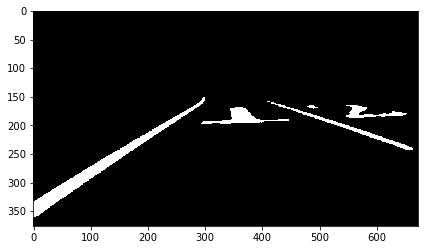

In [179]:
imshow(src)

Detected Lines (in red) - Standard Hough Line Transform


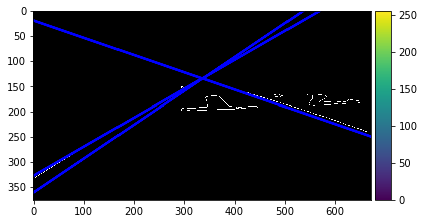

In [180]:
print("Detected Lines (in red) - Standard Hough Line Transform")
imshow(cdst)

Detected Lines (in red) - Probabilistic Line Transform


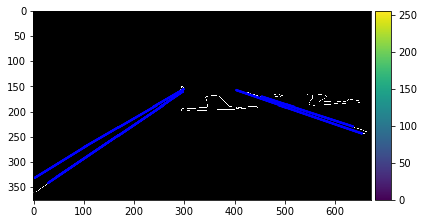

In [181]:
print("Detected Lines (in red) - Probabilistic Line Transform")
imshow(cdstP)

middle lines

In [238]:
def get_intersect(A, B, C, D):
    # a1x + b1y = c1
    a1 = B[1] - A[1]
    b1 = A[0] - B[0]
    c1 = a1 * (A[0]) + b1 * (A[1])

    # a2x + b2y = c2
    a2 = D[1] - C[1]
    b2 = C[0] - D[0]
    c2 = a2 * (C[0]) + b2 * (C[1])

    # determinant
    det = a1 * b2 - a2 * b1

    # parallel line
    if det == 0:
        return (float('inf'), float('inf'))

    # intersect point(x,y)
    x = ((b2 * c1) - (b1 * c2)) / det
    y = ((a1 * c2) - (a2 * c1)) / det
    return (x, y)

In [236]:
all_angles = []
for i in range(fd_linesp.shape[0]):
    l = filtered_linesp[i]
    start_pt = (l[0], l[1])
    end_pt = (l[2], l[3])
    angle = np.arctan(get_slope(start_pt, end_pt))
    all_angles.append(angle)
    print(start_pt, end_pt, angle)
print(max(all_angles))
print(min(all_angles))

(46, 330) (270, 179) -0.5931360286808669
(29, 342) (298, 160) -0.5948342649839622
(403, 157) (654, 243) 0.33009362660552644
(100, 271) (300, 155) -0.5255837935516102
(454, 170) (636, 229) 0.31348627973699106
(2, 332) (109, 266) -0.5526971916353038
0.33009362660552644
-0.5948342649839622


In [239]:
#line AB
A = (29, 342)
B = (298, 160)
C = (403, 157) 
D = (654, 243)
intersection_pt = get_intersect(A, B, C, D)
#get intersection of 2 lines
print(intersection_pt)

(336.2414990699837, 134.12656940246455)


archive

In [141]:
def white_color_segmentation(img, template):
    """
  Implement the cone detection using color segmentation algorithm
  Input:
    img: np.3darray; the input image with a cone to be detected. BGR.
    template_file_path; Not required, but can optionally be used to automate setting hue filter values.
  Return:
    bbox: ((x1, y1), (x2, y2)); the bounding box of the cone, unit in px
        (x1, y1) is the top left of the bbox and (x2, y2) is the bottom right of the bbox
    """
    ########## YOUR CODE STARTS HERE ##########
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # sensitivity = 15
    # lower_white = np.array([0,0,255-sensitivity])
    # upper_white = np.array([255,sensitivity,255])

    lower_white = np.array([0,0,200])
    upper_white = np.array([179,255,255])
  
    mask = cv2.inRange(img_hsv, upper_white, lower_white)
    masked_img = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)
    imshow(masked_img)
    return masked_img
    
#     #bounding box
#     h, s, v = cv2.split(masked_img)
#     ret, th1 = cv2.threshold(h,180,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     kernel = np.ones((1,1), dtype = "uint8")/9
#     bilateral = cv2.bilateralFilter(th1, 9 , 75, 75)
#     erosion = cv2.erode(bilateral, kernel, iterations = 1)
    
    
#     #finding the area of all connected white pixels in the image
#     pixel_components, output, stats, centroids =cv2.connectedComponentsWithStats(erosion, connectivity=8)
#     area = stats[1:, -1]; pixel_components = pixel_components - 1
#     min_size = 50#500 #1000

#     img2 = np.zeros((output.shape))
#     #Removing the small white pixel area below the minimum size
#     for i in range(0, pixel_components):
#         if area[i] >= min_size:
#             img2[output == i + 1] = 255

#     img3 = masked_img.astype(np.uint8) 
   
#     # find contours and bounding rectangle in the thresholded image
#     try: 
#         cnts, _ = cv2.findContours(img3.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]
#         rect = cv2.boundingRect(cnts[0])
#         x,y,w,h = rect #(x,y) be the top-left coordinate of the rectangle and (w,h) be its width and height.

#         #visualize
#         img_final = img.copy()
#         #img_final = cv2.drawContours(img_final,cnts[0],0,(0,255,255),2)
#         img_final = cv2.rectangle(img_final, (x,y),(x+w,y+h),(0,255,0),2)
#         #image_print(img_final)
#         imshow(img_final)
        
#         print("success")
#         return img_final

#     except:
#         x,y,w,h = 0,0,0,0

#     bounding_box = ((x,y),(x+w,y+h))

#     ########### YOUR CODE ENDS HERE ###########

#     # Return bounding box
#     return masked_img#bounding_box